# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [2]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [3]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


class ReshapeTransform:
    def __init__(self, new_shape):
        self.new_shape = new_shape

    def __call__(self, img):
        return img.view(*self.new_shape)

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    ReshapeTransform((1, 28, 28))
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [4]:
class ConvEncoder(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)  # Output: [32, 28, 28]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)             # Output: [64, 28, 28]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)            # Output: [128, 28, 28]
        self.conv4 = nn.Conv2d(128, hidden_dim, kernel_size=3, stride=1, padding=1)    # Output: [hidden_dim, 28, 28]
        
        self.pool = nn.MaxPool2d(2, 2)  # Pool size 2x2

        # Convolutional layers to map to latent dimensions
        self.conv_mean = nn.Conv2d(hidden_dim, latent_dim, kernel_size=3, stride=1, padding=1)
        self.conv_var = nn.Conv2d(hidden_dim, latent_dim, kernel_size=3, stride=1, padding=1)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling

    def forward(self, x):
        h = self.LeakyReLU(self.conv1(x))
        h = self.pool(h)  # Output: [batch_size, 32, 14, 14]
        h = self.LeakyReLU(self.conv2(h))
        h = self.pool(h)  # Output: [batch_size, 64, 7, 7]
        h = self.LeakyReLU(self.conv3(h))
        h = self.pool(h)  # Output: [batch_size, 128, 3, 3]
        h = self.LeakyReLU(self.conv4(h))
        h = self.pool(h)  # Output: [batch_size, hidden_dim, 1, 1]

        # Mean and log variance layers
        mean = self.avgpool(self.conv_mean(h))  # Output: [batch_size, latent_dim, 1, 1]
        log_var = self.avgpool(self.conv_var(h))  # Output: [batch_size, latent_dim, 1, 1]

        mean = mean.squeeze(-1).squeeze(-1)  # Remove last two dimensions
        log_var = log_var.squeeze(-1).squeeze(-1)  # Remove last two dimensions

        return mean, log_var

In [5]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_channels):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim * 7 * 7)  # Output size 7x7 before deconv layers
        
        # Adjust the conv transpose layers to ensure the output size matches the input size
        self.deconv1 = nn.ConvTranspose2d(hidden_dim, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: [128, 14, 14]
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)         # Output: [64, 28, 28]
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)  # Output: [32, 28, 28]
        self.deconv4 = nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=1, padding=1)  # Output: [1, 28, 28]
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc(x))
        h = h.view(h.size(0), -1, 7, 7)  # Reshape to [batch_size, hidden_dim, 7, 7]
        h = self.LeakyReLU(self.deconv1(h))  # [batch_size, 128, 14, 14]
        h = self.LeakyReLU(self.deconv2(h))  # [batch_size, 64, 28, 28]
        h = self.LeakyReLU(self.deconv3(h))  # [batch_size, 32, 28, 28]
        x_hat = torch.sigmoid(self.deconv4(h))  # [batch_size, output_channels, 28, 28]
        return x_hat

In [6]:
class ConvVAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(ConvVAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)
        z = mean + var * epsilon
        return z
        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [7]:
input_channels = 1  # For grayscale images, change to 3 for RGB
encoder = ConvEncoder(input_channels=input_channels, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = ConvDecoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_channels=input_channels)

model = ConvVAE(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [8]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [9]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        # x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        print(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


	Epoch 1 complete! 	Average Loss:  168.9449654534902
	Epoch 2 complete! 	Average Loss:  118.72842235431449
	Epoch 3 complete! 	Average Loss:  108.39038532645556
	Epoch 4 complete! 	Average Loss:  105.24831044905572
	Epoch 5 complete! 	Average Loss:  103.41187509781928
	Epoch 6 complete! 	Average Loss:  102.1296757127765
	Epoch 7 complete! 	Average Loss:  101.37415021128965
	Epoch 8 complete! 	Average Loss:  100.56225866352776
	Epoch 9 complete! 	Average Loss:  99.97503148150564
	Epoch 10 complete! 	Average Loss:  99.40392457481218
	Epoch 11 complete! 	Average Loss:  99.05941199199187
	Epoch 12 complete! 	Average Loss:  98.61508821668927
	Epoch 13 complete! 	Average Loss:  98.2913705296588
	Epoch 14 complete! 	Average Loss:  97.89346629147538
	Epoch 15 complete! 	Average Loss:  97.61287552822412
	Epoch 16 complete! 	Average Loss:  97.29690961172267
	Epoch 17 complete! 	Average Loss:  96.98543906184787
	Epoch 18 complete! 	Average Loss:  96.75396119183013
	Epoch 19 complete! 	Average Los

### Step 5. Generate images from test dataset

In [10]:
import matplotlib.pyplot as plt

In [12]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        # x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [13]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

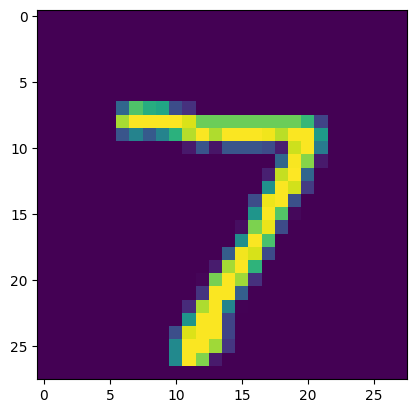

In [14]:
show_image(x, idx=0)

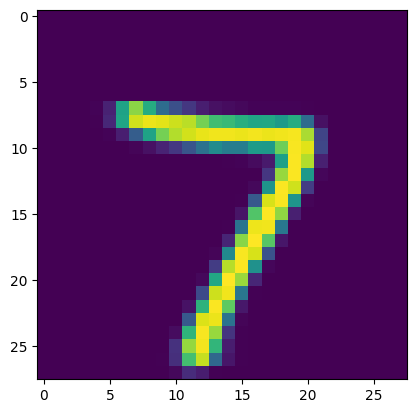

In [15]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [16]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [17]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

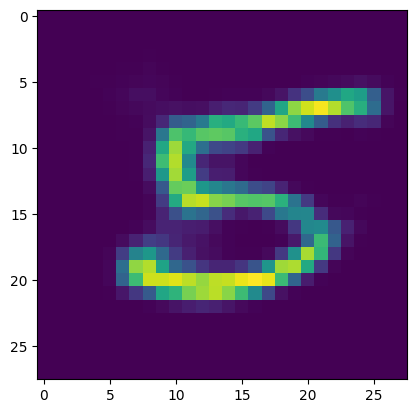

In [18]:
show_image(generated_images, idx=12)

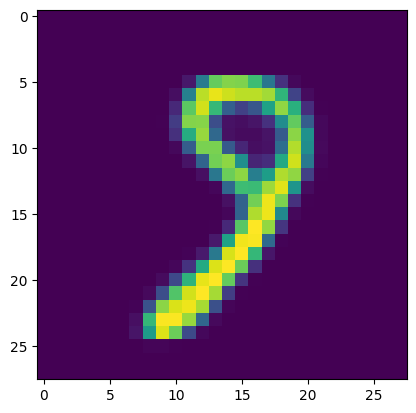

In [19]:
show_image(generated_images, idx=0)

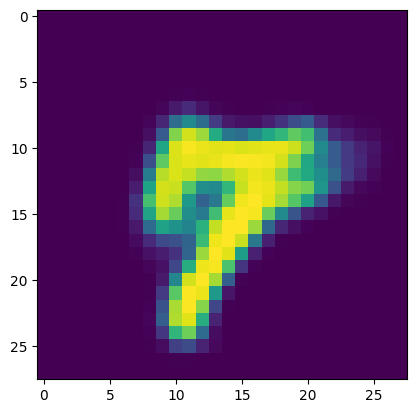

In [20]:
show_image(generated_images, idx=1)

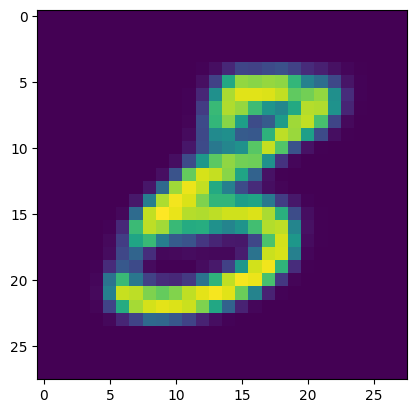

In [21]:
show_image(generated_images, idx=10)

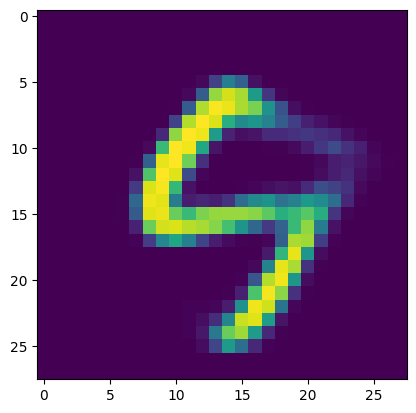

In [22]:
show_image(generated_images, idx=20)

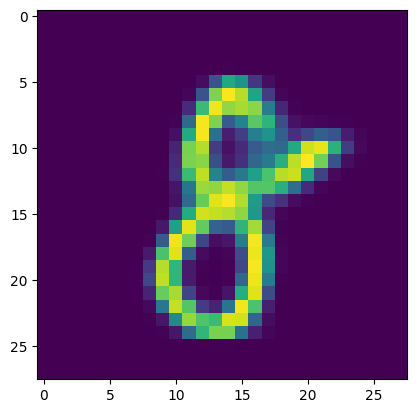

In [23]:
show_image(generated_images, idx=50)